# Partie 1

In [88]:
import pandas as pd
import re
import numpy as np

def extract_data(input_path, pattern):
    with open(input_path, 'r') as file:
        content = file.read()
    matches = re.findall(pattern, content, re.MULTILINE)
    data = []
    for match in matches:
        numbers = match[1].replace('\n', ' ').split()
        numbers_float = [float(number) for number in numbers]
        data.append(numbers_float)
    return pd.DataFrame(data)

rocks_path = 'data/sonar.rocks'
mines_path = 'data/sonar.mines'


train_pattern = r'\*(CR|CM)\d+:\n\{([\d\s\.\n]+)\}'
test_pattern = r'^(?!\*)(CR|CM)\d+:\n\{([\d\s\.\n]+)\}'


rocks_train_df = extract_data(rocks_path, train_pattern)
mines_train_df = extract_data(mines_path, train_pattern)
rocks_train_df['Label'] = 'R'  
mines_train_df['Label'] = 'M' 
train_df = pd.concat([rocks_train_df, mines_train_df], ignore_index=True).sample(frac=1).reset_index(drop=True)

rocks_test_df = extract_data(rocks_path, test_pattern)
mines_test_df = extract_data(mines_path, test_pattern)
rocks_test_df['Label'] = 'R'  
mines_test_df['Label'] = 'M' 
test_df = pd.concat([rocks_test_df, mines_test_df], ignore_index=True).sample(frac=1).reset_index(drop=True)

## Algorithme d'entraînement

In [89]:
def predict_perceptron(inputs, weights):
    activation = np.dot(inputs, weights[1:]) + weights[0]
    return 1 if activation >= 0 else -1


def calculate_accuracy(features, labels, weights):
    predictions = [predict_perceptron(x, weights) for x in features]
    correct_predictions = sum(pred == label for pred, label in zip(predictions, labels))
    accuracy = correct_predictions / len(labels)
    return accuracy

def calculate_error(weights, training_features, training_labels):
    errors = 0
    for inputs, label in zip(training_features, training_labels):
        inputs_with_bias = np.insert(inputs, 0, 1)
        prediction = np.sign(np.dot(weights, inputs_with_bias))
        if prediction != label:
            errors += 1
    return errors


In [90]:
def minimerror_perceptron(weightsT,training_features, training_labels, epochs, learning_rate, T_initial, T_decrease_factor, patience=200):
    T = T_initial
    weights = weightsT
    previous_errors = float('inf')
    no_improvement_count = 0  # Compter le nombre d'époques sans amélioration
    current_errors = np.zeros(epochs)
    for epoch in range(epochs):
        for inputs, label in zip(training_features, training_labels):
            inputs_with_bias = np.insert(inputs, 0, 1)
            stability = (np.dot(inputs_with_bias, weights) * label) / np.linalg.norm(weights[1:])
            derivative = -inputs_with_bias * label / (4 * T * np.cosh(stability / (2 * T))**2)
            weights[1:] -= learning_rate * derivative[1:] / np.linalg.norm(weights[1:])
            weights[0] -= learning_rate * derivative[0]

        current_errors[epoch] = calculate_error(weights, training_features, training_labels)
        
        if current_errors[epoch] < previous_errors:
            previous_errors = current_errors[epoch]
            no_improvement_count = 0  # Réinitialiser le compteur car il y a eu amélioration
            weightsT = weights
        else:
            no_improvement_count += 1  # Incrémenter le compteur d'absence d'amélioration

        # Arrêter si aucune amélioration n'a été constatée après un certain nombre d'époques ('patience')
        if no_improvement_count >= patience:
            print(f'Arrêt prématuré après {epoch+1} époques en raison de l\'absence d\'amélioration.')
            break

        # Diminution de la température T pour l'itération suivante
        T *= T_decrease_factor

        # Informations de débogage
        print(f'Epoch {epoch+1}/{epochs}, Erreurs: {current_errors[epoch]}, Température: {T}')

    return weightsT, current_errors[:epoch+1]


In [91]:
weightsT = np.random.uniform(low=0.3, high=0.4, size=train_features.shape[1] + 1)
print(weightsT) 
train_df['Label'] = train_df['Label'].apply(lambda x: 1 if x == 'M' else -1)
test_df['Label'] = test_df['Label'].apply(lambda x: 1 if x == 'M' else -1)


test_features = test_df.iloc[:, :-1].values
test_labels = test_df.iloc[:, -1].values


train_features = train_df.iloc[:, :-1].values
train_labels = train_df.iloc[:, -1].values

# Exemple d'utilisation de la méthode minimerror_perceptron:
weights3,errors = minimerror_perceptron(weightsT,train_features, train_labels, epochs=10000, learning_rate=0.02, T_initial=80, T_decrease_factor=0.99, patience=500)
print(weights3)
training_accuracy3 = calculate_accuracy(train_features, train_labels, weights3)
testing_accuracy3 = calculate_accuracy(test_features, test_labels, weights3)


Ea3 = 1 - training_accuracy3
Eg3 = 1 - testing_accuracy3

print(f"Erreur d'apprentissage (Ea) : {Ea3}")
print(f"Erreur de généralisation (Eg) : {Eg3}")

[0.38828604 0.32744926 0.39623252 0.30172784 0.3519849  0.33412232
 0.30813254 0.39488673 0.32799859 0.30521832 0.33124553 0.35132125
 0.34178342 0.35545304 0.37527068 0.3032396  0.38743526 0.31557087
 0.39286132 0.30748266 0.39444562 0.3056815  0.33359299 0.32559228
 0.34316445 0.3901696  0.38434729 0.33809857 0.33899868 0.34182733
 0.34425347 0.30524385 0.37216488 0.30220822 0.37406631 0.32015091
 0.35957248 0.34650032 0.3539989  0.38790843 0.32999808 0.37744037
 0.33160506 0.38516036 0.3806869  0.31729524 0.3190175  0.38237699
 0.35821476 0.37392391 0.35724225 0.34378928 0.32486534 0.37755072
 0.39704579 0.30294096 0.33418621 0.39447153 0.3131256  0.38051831
 0.39727111]
Epoch 1/10000, Erreurs: 55.0, Température: 79.2
Epoch 2/10000, Erreurs: 55.0, Température: 78.408
Epoch 3/10000, Erreurs: 55.0, Température: 77.62392
Epoch 4/10000, Erreurs: 55.0, Température: 76.84768079999999
Epoch 5/10000, Erreurs: 55.0, Température: 76.07920399199999
Epoch 6/10000, Erreurs: 55.0, Température: 75

C:\Users\Administrator\AppData\Local\Temp\ipykernel_56552\1722818886.py:11: RuntimeWarning: overflow encountered in scalar power
  derivative = -inputs_with_bias * label / (4 * T * np.cosh(stability / (2 * T))**2)


Epoch 1149/10000, Erreurs: 15.0, Température: 0.0007725535269835329
Epoch 1150/10000, Erreurs: 15.0, Température: 0.0007648279917136975
Epoch 1151/10000, Erreurs: 15.0, Température: 0.0007571797117965606
Epoch 1152/10000, Erreurs: 15.0, Température: 0.0007496079146785949
Epoch 1153/10000, Erreurs: 15.0, Température: 0.0007421118355318089
Epoch 1154/10000, Erreurs: 15.0, Température: 0.0007346907171764908
Epoch 1155/10000, Erreurs: 15.0, Température: 0.0007273438100047259
Epoch 1156/10000, Erreurs: 15.0, Température: 0.0007200703719046787
Epoch 1157/10000, Erreurs: 15.0, Température: 0.0007128696681856319
Epoch 1158/10000, Erreurs: 15.0, Température: 0.0007057409715037756
Epoch 1159/10000, Erreurs: 15.0, Température: 0.0006986835617887378
Epoch 1160/10000, Erreurs: 15.0, Température: 0.0006916967261708504
Epoch 1161/10000, Erreurs: 15.0, Température: 0.000684779758909142
Epoch 1162/10000, Erreurs: 15.0, Température: 0.0006779319613200506
Epoch 1163/10000, Erreurs: 15.0, Température: 0.0

C:\Users\Administrator\AppData\Local\Temp\ipykernel_56552\1722818886.py:11: RuntimeWarning: overflow encountered in cosh
  derivative = -inputs_with_bias * label / (4 * T * np.cosh(stability / (2 * T))**2)


Epoch 1202/10000, Erreurs: 15.0, Température: 0.0004535173363548666
Epoch 1203/10000, Erreurs: 15.0, Température: 0.00044898216299131793
Epoch 1204/10000, Erreurs: 15.0, Température: 0.00044449234136140475
Epoch 1205/10000, Erreurs: 15.0, Température: 0.0004400474179477907
Epoch 1206/10000, Erreurs: 15.0, Température: 0.0004356469437683128
Epoch 1207/10000, Erreurs: 15.0, Température: 0.00043129047433062965
Epoch 1208/10000, Erreurs: 15.0, Température: 0.00042697756958732337
Epoch 1209/10000, Erreurs: 15.0, Température: 0.0004227077938914501
Epoch 1210/10000, Erreurs: 15.0, Température: 0.0004184807159525356
Epoch 1211/10000, Erreurs: 15.0, Température: 0.0004142959087930102
Epoch 1212/10000, Erreurs: 15.0, Température: 0.0004101529497050801
Epoch 1213/10000, Erreurs: 15.0, Température: 0.0004060514202080293
Epoch 1214/10000, Erreurs: 15.0, Température: 0.000401990906005949
Epoch 1215/10000, Erreurs: 15.0, Température: 0.0003979709969458895
Epoch 1216/10000, Erreurs: 15.0, Température:

Stabilité : 0.1573754070901225
Accuracy sur le jeu d'entraînement : 0.8557692307692307
Accuracy sur le jeu de test : 0.7307692307692307
Erreur d'apprentissage (Ea) : 0.14423076923076927
Erreur de généralisation (Eg) : 0.2692307692307693
Stabilité : 0.1573754070901225
Poids : [-7.66156218  0.62951826  1.41117065  1.26198128  2.04395611  1.87730586
  1.12282819  0.77334734  0.37746666  2.53648265  2.62531818  3.06744767
  2.4857672   1.51766411  0.38936213 -0.84908155 -1.5997451  -1.28481656
 -0.62880494  0.09487933 -0.48735444 -0.15271209  1.59506973  0.95230052
  0.11516036  0.16893273  0.32477097  1.3427459   1.89110947  0.9867146
  1.14840235 -0.8782739   0.64078886 -0.55754635 -0.88736839 -1.83928821
 -2.53094403 -1.39792043  0.35243704 -0.22769956  0.22917614  2.36963625
  0.34262393 -0.14914896  1.28513973  2.85571267  2.15086192  2.02447909
  1.95056172  1.66965661  0.43135609  0.54617147  0.57096999  0.4300086
  0.51559938  0.30336761  0.32407354  0.36971469  0.36533285  0.39258

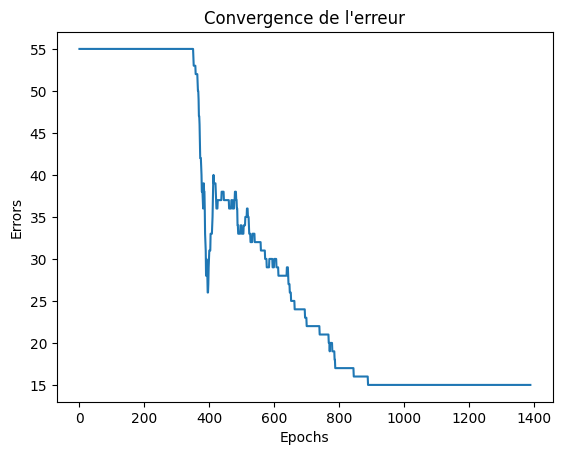

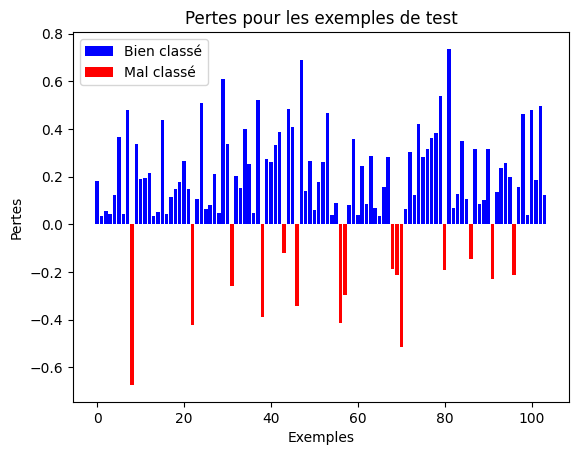

In [94]:
# affichage de stabilité
stability = []
for inputs, label in zip(train_features, train_labels):
    inputs_with_bias = np.insert(inputs, 0, 1)
    stability.append((np.dot(inputs_with_bias, weights3) * label) / np.linalg.norm(weights3[1:]))
print(f"Stabilité : {np.mean(stability)}")

# affichage des résultats
print(f"Accuracy sur le jeu d'entraînement : {training_accuracy3}")
print(f"Accuracy sur le jeu de test : {testing_accuracy3}")

print(f"Erreur d'apprentissage (Ea) : {Ea3}")
print(f"Erreur de généralisation (Eg) : {Eg3}")
print(f"Stabilité : {np.mean(stability)}")
print(f"Poids : {weights3}")

# Affichage de graphique de convergence de l'erreur
import matplotlib.pyplot as plt
plt.plot(range(len(errors)), errors)
plt.xlabel('Epochs')
plt.ylabel('Errors')
plt.title('Convergence de l\'erreur')
plt.show()



# Affichage du graphique
plt.bar(range(len(stability)), [val if val > 0 else 0 for val in stability], 
        color='blue', label='Bien classé')

# Barres pour les exemples classés comme roches
plt.bar(range(len(stability)), [val if val < 0 else 0 for val in stability], 
        color='red', label='Mal classé')

# Ajout des étiquettes
plt.xlabel('Exemples')
plt.ylabel('Pertes')
plt.title('Pertes pour les exemples de test')
plt.legend()
plt.show()

PARTIE 2 :

In [95]:


def minimerror_perceptron4(training_features, training_labels, epochs, initial_learning_rate, T_plus_initial, T_minus_initial, T_decrease_factor, patience, decay):
    weights = np.random.uniform(low=0.3, high=0.4, size=(training_features.shape[1] + 1))
    T_plus = T_plus_initial
    T_minus = T_minus_initial
    previous_errors = float('inf')
    no_improvement_count = 0
    learning_rate = initial_learning_rate

    for epoch in range(epochs):
        for inputs, label in zip(training_features, training_labels):
            inputs_with_bias = np.insert(inputs, 0, 1)
            stability = (np.dot(inputs_with_bias, weights) * label) / np.linalg.norm(weights[1:])
            T = T_plus if stability >= 0 else T_minus
            derivative = -inputs_with_bias * label / (4 * T * np.cosh(stability / (2 * T))**2)
            weights[1:] -= learning_rate * derivative[1:] / np.linalg.norm(weights[1:])
            weights[0] -= learning_rate * derivative[0]

        current_errors = calculate_error(weights, training_features, training_labels)

        if current_errors < previous_errors:
            previous_errors = current_errors
            no_improvement_count = 0
            # Diminuez les températures lorsque les erreurs s'améliorent
            T_plus *= T_decrease_factor
            T_minus *= T_decrease_factor
        else:
            no_improvement_count += 1
            # Augmentez les températures si les erreurs augmentent ou stagnent
            T_plus /= T_decrease_factor
            T_minus /= T_decrease_factor

        if no_improvement_count >= patience:
            print(f'Arrêt prématuré après {epoch+1} époques en raison de l\'absence d\'amélioration.')
            break

        # Réduisez le taux d'apprentissage progressivement
        learning_rate *= (1.0 / (1.0 + decay * epoch))

        print(f'Epoch {epoch+1}/{epochs}, Erreurs: {current_errors}, T+: {T_plus}, T-: {T_minus}, Learning Rate: {learning_rate}')

    return weights

# Exemple d'utilisation de la méthode minimerror_perceptron :
# Vous devrez définir training_features, training_labels et ajuster les hyperparamètres ci-dessous selon votre cas d'usage.

# Exemple d'utilisation de la méthode minimerror_perceptron:
weights4 = minimerror_perceptron4(train_features, train_labels, epochs=10000, initial_learning_rate=0.02, T_plus_initial=100, T_minus_initial=1, T_decrease_factor=0.99, patience=200, decay=1e-6)



training_accuracy3 = calculate_accuracy(train_features, train_labels, weights4)
testing_accuracy3 = calculate_accuracy(test_features, test_labels, weights4)


Ea3 = 1 - training_accuracy3
Eg3 = 1 - testing_accuracy3

print(f"Erreur d'apprentissage (Ea) : {Ea3}")
print(f"Erreur de généralisation (Eg) : {Eg3}")

Epoch 1/10000, Erreurs: 55, T+: 99.0, T-: 0.99, Learning Rate: 0.02
Epoch 2/10000, Erreurs: 55, T+: 100.0, T-: 1.0, Learning Rate: 0.019999980000020002
Epoch 3/10000, Erreurs: 55, T+: 101.01010101010101, T-: 1.0101010101010102, Learning Rate: 0.01999994000014
Epoch 4/10000, Erreurs: 55, T+: 102.03040506070809, T-: 1.020304050607081, Learning Rate: 0.0199998800005
Epoch 5/10000, Erreurs: 55, T+: 103.06101521283645, T-: 1.0306101521283648, Learning Rate: 0.0199998000013
Epoch 6/10000, Erreurs: 55, T+: 104.10203556852167, T-: 1.041020355685217, Learning Rate: 0.019999700002799985
Epoch 7/10000, Erreurs: 55, T+: 105.15357128133502, T-: 1.0515357128133505, Learning Rate: 0.019999580005319952
Epoch 8/10000, Erreurs: 55, T+: 106.21572856700507, T-: 1.062157285670051, Learning Rate: 0.019999440009239887
Epoch 9/10000, Erreurs: 44, T+: 105.15357128133502, T-: 1.0515357128133505, Learning Rate: 0.019999280014999767
Epoch 10/10000, Erreurs: 42, T+: 104.10203556852167, T-: 1.041020355685217, Learn